In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from src.model.models import Surebet
import matplotlib.dates as mdates
from typing import List
import matplotlib
from src.repository.surebet_repository import SurebetRepository
from datetime import timedelta
from pandas import Timestamp

In [2]:
def config_plot(plt: matplotlib.pyplot):
    # Defina o tamanho da figura (largura x altura) em polegadas
    largura_figura = 20  # Ajuste a largura
    altura_figura = 6    # Ajuste a altura
    plt.figure(figsize=(largura_figura, altura_figura))
    
    plt.xticks(rotation=90)
    
    # Ative as grades nos eixos x e y
    plt.grid(True)

def plotar(df: pd.DataFrame, eixos: tuple):
    plt = matplotlib.pyplot
    config_plot(plt)
    plt.xlabel('Hora')
    plt.ylabel('Quantidade Surebet')
    plt.title('Gráfico de Surebet por data')
    
    df = df.query(f'{eixos[1]} != 0')
    plt.scatter(df[f'{eixos[0]}'], df[f'{eixos[1]}'])
    
    plt.show()

In [3]:
repository = SurebetRepository()



In [87]:
def list_to_dataframe(dados: List[Surebet]) -> pd.DataFrame:
    df = pd.DataFrame.from_records([vars(i) for i in dados])
    df = df[['game_id', 'bookmaker_key_OVER', 'bookmaker_key_UNDER', 'odd_OVER', 'odd_UNDER', 'last_update_OVER', 'last_update_UNDER', 'profit']]
    return df

def gerar_label_intervalo(intervalos: List[pd.Timestamp]) -> List[str]:
    return [f"{data} - {proxima_data}" for data, proxima_data in zip(intervalos, intervalos[1:])]
    

def setar_intervalo_df(dados: List[Surebet], range: tuple, freq: str) -> pd.DataFrame:
    """
    Define intervalos de tempo em um DataFrame com base em um range e uma frequência.

    Esta função recebe uma lista de Surebets, um range de datas e uma frequência e cria uma nova coluna
    no DataFrame resultante que associa cada registro a um intervalo de tempo correspondente.

    Args:
        dados (List[Surebet]): Uma lista de objetos Surebet contendo os dados a serem processados.
        range (tuple): Uma tupla que especifica o início e o fim do intervalo de datas no formato 'AAAA-MM-DD'.
        freq (str): Uma string que especifica a frequência para criar os intervalos de tempo, por exemplo, '15T' para 15 minutos.

    Returns:
        pd.DataFrame: Um novo DataFrame com a coluna 'intervalo' contendo os intervalos correspondentes.
    """
    df = list_to_dataframe(dados)
    
    # Definir os intervalos manualmente
    intervalos = pd.date_range(start=f'{range[0]}', end=f'{range[1]}', freq=f'{freq}')
    mask_format = '%H:%M:%S' if ('T' in freq or 'H' in freq) else '%Y-%m-%d'
    intervalos_label = [i.strftime(mask_format) for i in intervalos]

    # Arredondando os minutos com base nos segundos
    df['last_update_OVER'] = df['last_update_OVER'].dt.round('T')

    posicao = df.columns.get_loc('last_update_UNDER')  # Obtém o índice da coluna 'last_update_UNDER'

    # Criar uma nova coluna com o intervalo correspondente a cada registro
    df.insert(posicao, 'intervalo', pd.cut(df['last_update_OVER'], bins=intervalos, labels=gerar_label_intervalo(intervalos_label)))
    
    return df


In [88]:
start_date = '2023-08-01 00:00:00'
end_date = '2023-09-03 23:59:59'
lista_surebet = repository.find_all_between(start_date, end_date)
r = setar_intervalo_df(lista_surebet, (start_date, end_date), 'D')
r.head()


,game_id,bookmaker_key_OVER,bookmaker_key_UNDER,odd_OVER,odd_UNDER,last_update_OVER,intervalo,last_update_UNDER,profit
0,213f7fcf03790372df563ce3f9671d53,MATCHBOOK,UNIBET_EU,1.69,2.50,2023-08-05 20:30:00,2023-08-05 - 2023-08-06,2023-08-05 20:29:53,0.828402
1,213f7fcf03790372df563ce3f9671d53,MATCHBOOK,UNIBET_EU,1.69,2.50,2023-08-05 20:59:00,2023-08-05 - 2023-08-06,2023-08-05 20:59:29,0.828402
2,f1d20168f79cc262e99f1d79631110d5,PINNACLE,UNIBET_EU,1.91,2.40,2023-09-02 12:45:00,2023-09-02 - 2023-09-03,2023-09-02 12:59:19,5.977312
3,f1d20168f79cc262e99f1d79631110d5,UNIBET_EU,PINNACLE,2.07,1.94,2023-09-02 11:53:00,2023-09-02 - 2023-09-03,2023-09-02 11:53:25,0.144430
4,f1d20168f79cc262e99f1d79631110d5,UNIBET_EU,PINNACLE,2.07,1.94,2023-09-02 11:53:00,2023-09-02 - 2023-09-03,2023-09-02 11:48:25,0.144430


In [94]:
r = r.groupby('intervalo').size().reset_index(name='quantidade')
r = r.query('quantidade != 0')
r.head()
# plotar(r, ('intervalo', 'quantidade'))
# 

,intervalo,quantidade
0,2023-08-01 - 2023-08-02,1
1,2023-08-02 - 2023-08-03,1
2,2023-08-03 - 2023-08-04,1
3,2023-08-04 - 2023-08-05,1
4,2023-08-05 - 2023-08-06,1


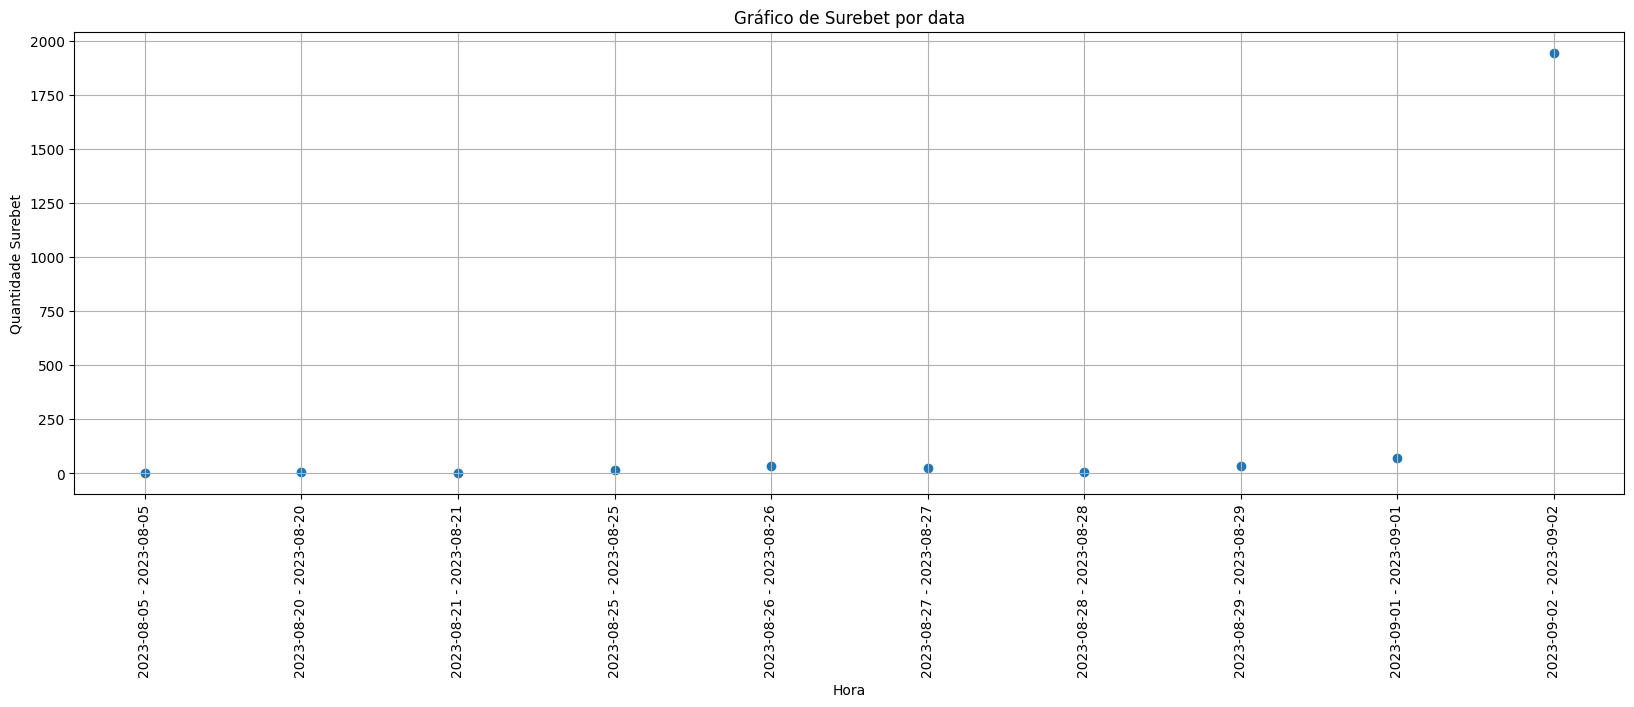

In [59]:
resultado = r.groupby('intervalo').size().reset_index(name='quantidade')
plotar(resultado, ('intervalo', 'quantidade'))
